In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_ebsp = pd.read_csv("../data/ebsp_clean.csv")
df_ebsp['t'] = pd.to_datetime(df_ebsp['t'])
df_ebsp.head(3)

,t,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55


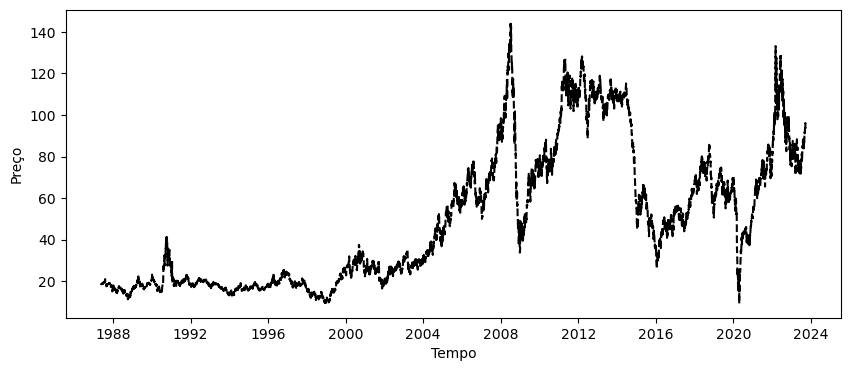

In [3]:
plt.figure(figsize=(10, 4))

plt.plot(df_ebsp.t, df_ebsp.price, label='y = x', color='black', linestyle='--')
plt.xlabel('Tempo')
plt.ylabel('Preço')

plt.savefig('../imagens/ebsp.png')

plt.show()

In [4]:
df = pd.read_csv("../data/simulations/900/sim_df.csv")
df_meta = pd.read_csv("../data/simulations/900/meta.csv")

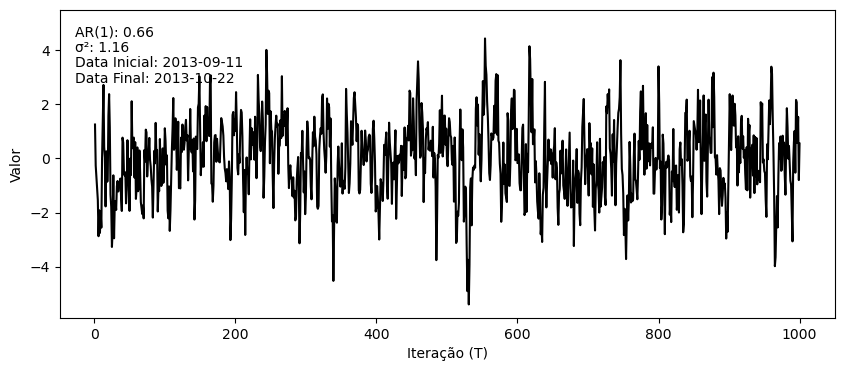

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(df.t, df.V1, color='black')
plt.xlabel('Iteração (T)')
plt.ylabel('Valor')

# Informações para anotar
ar1 = 0.66
sigma2 = 1.16
data_inicial = '2013-09-11'
data_final = '2013-10-22'

# Ajuste as coordenadas (x, y) conforme necessário
plt.text(0.02, 0.95, f'AR(1): {ar1}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.02, 0.90, f'σ²: {sigma2}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.02, 0.85, f'Data Inicial: {data_inicial}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.02, 0.80, f'Data Final: {data_final}', transform=plt.gca().transAxes, verticalalignment='top')
plt.gca().set_ylim(top = 5.5)

plt.savefig("../imagens/exemplo_série_sintética.png")

plt.show()

In [6]:
def aplicar_drift(df, coluna='V1', tipo='abrupto',
                  pontos_drift=None, aleatorio=False, 
                  num_pontos=1, duracao_drift=None, **kwargs):

    n = len(df)
    if aleatorio and tipo != 'incremental':
        pontos_drift = np.sort(np.random.choice(df.index, num_pontos, replace=False))
    elif aleatorio and tipo == 'incremental' and duracao_drift is not None:
        inicio_drift = np.random.randint(0, n - duracao_drift)
        termino_drift = inicio_drift + duracao_drift
        pontos_drift = [inicio_drift, termino_drift]
    elif pontos_drift is None:
        pontos_drift = [n // 2]  # Ponto médio se nenhum ponto for fornecido e aleatorio=False

    if tipo == 'abrupto':
        delta = kwargs.get('delta', np.random.normal(10, 1))  # Default: distribuição normal N(10, 1)
        for ponto in pontos_drift:
            df.loc[df.index >= ponto, coluna] += delta

    elif tipo == 'incremental':
        if duracao_drift is None:
            duracao_drift = np.random.randint(50, 150) 
        if aleatorio:
            inicio_drift = np.random.randint(0, n - duracao_drift)
            termino_drift = inicio_drift + duracao_drift
            print(inicio_drift)
            print(termino_drift)
        else:
            inicio_drift = kwargs.get('inicio_drift', 0)
            termino_drift = kwargs.get('termino_drift', inicio_drift + duracao_drift)

        incremento_base = kwargs.get('incremento', np.random.normal(0.1, 0.05))
        variancia_base = kwargs.get('variancia', 0.02)
        amplitude_variacao = kwargs.get('amplitude_variacao', 0.05)  # Amplitude da variação no incremento
        frequencia_variacao = kwargs.get('frequencia_variacao', np.pi/(termino_drift - inicio_drift))  # Define a frequência da variação sinusoidal

        for i in range(inicio_drift, termino_drift + 1):
            # Calcula um incremento que varia ao longo do tempo, adicionando uma componente sinusoidal
            variacao_sinusoidal = amplitude_variacao * np.sin(frequencia_variacao * (i - inicio_drift))
            incremento_atual = incremento_base + variacao_sinusoidal + np.random.normal(0, variancia_base)

            # Aplica o incremento, ajustando pela distância do início do drift
            df.loc[i, coluna] += (i - inicio_drift) * incremento_atual
        
        # Calcula o aumento a ser aplicado aos valores após o término do drift
        aumento = df.loc[termino_drift, coluna]
        print(aumento)
        
        # Aplica o aumento aos valores restantes da série
        for i in range(termino_drift + 1, n):
            df.loc[i, coluna] += aumento

    elif tipo == 'recorrente':
        # Gera um período aleatório entre 50 e 200. Isso assegura uma variabilidade na frequência das oscilações
        # Menores valores de período gerarão mais oscilações, maiores valores gerarão menos oscilações
        periodo = kwargs.get('periodo', np.random.randint(50, 201))

        # Gera uma amplitude aleatória entre 3 e 10. Isso assegura variabilidade na intensidade das oscilações
        # Amplitudes maiores farão as oscilações serem mais pronunciadas
        amplitude = kwargs.get('amplitude', np.random.uniform(3, 10))

        for i in range(n):
            df.loc[i, coluna] += amplitude * np.sin(2 * np.pi * df.loc[i, 't'] / periodo)

    else:
        raise ValueError("Tipo de drift não suportado. Escolha entre 'abrupto','incremental', 'recorrente'.")

    return df

In [7]:
temp = df.copy()
df_abrupto = aplicar_drift(temp, tipo='abrupto', aleatorio=True, num_pontos=2, delta=5)

temp = df.copy()
df_incremental = aplicar_drift(temp,tipo='incremental',aleatorio=True)

temp = df.copy()
df_recorrente= aplicar_drift(temp,tipo='recorrente',aleatorio=True)

457
533
6.720160738057768


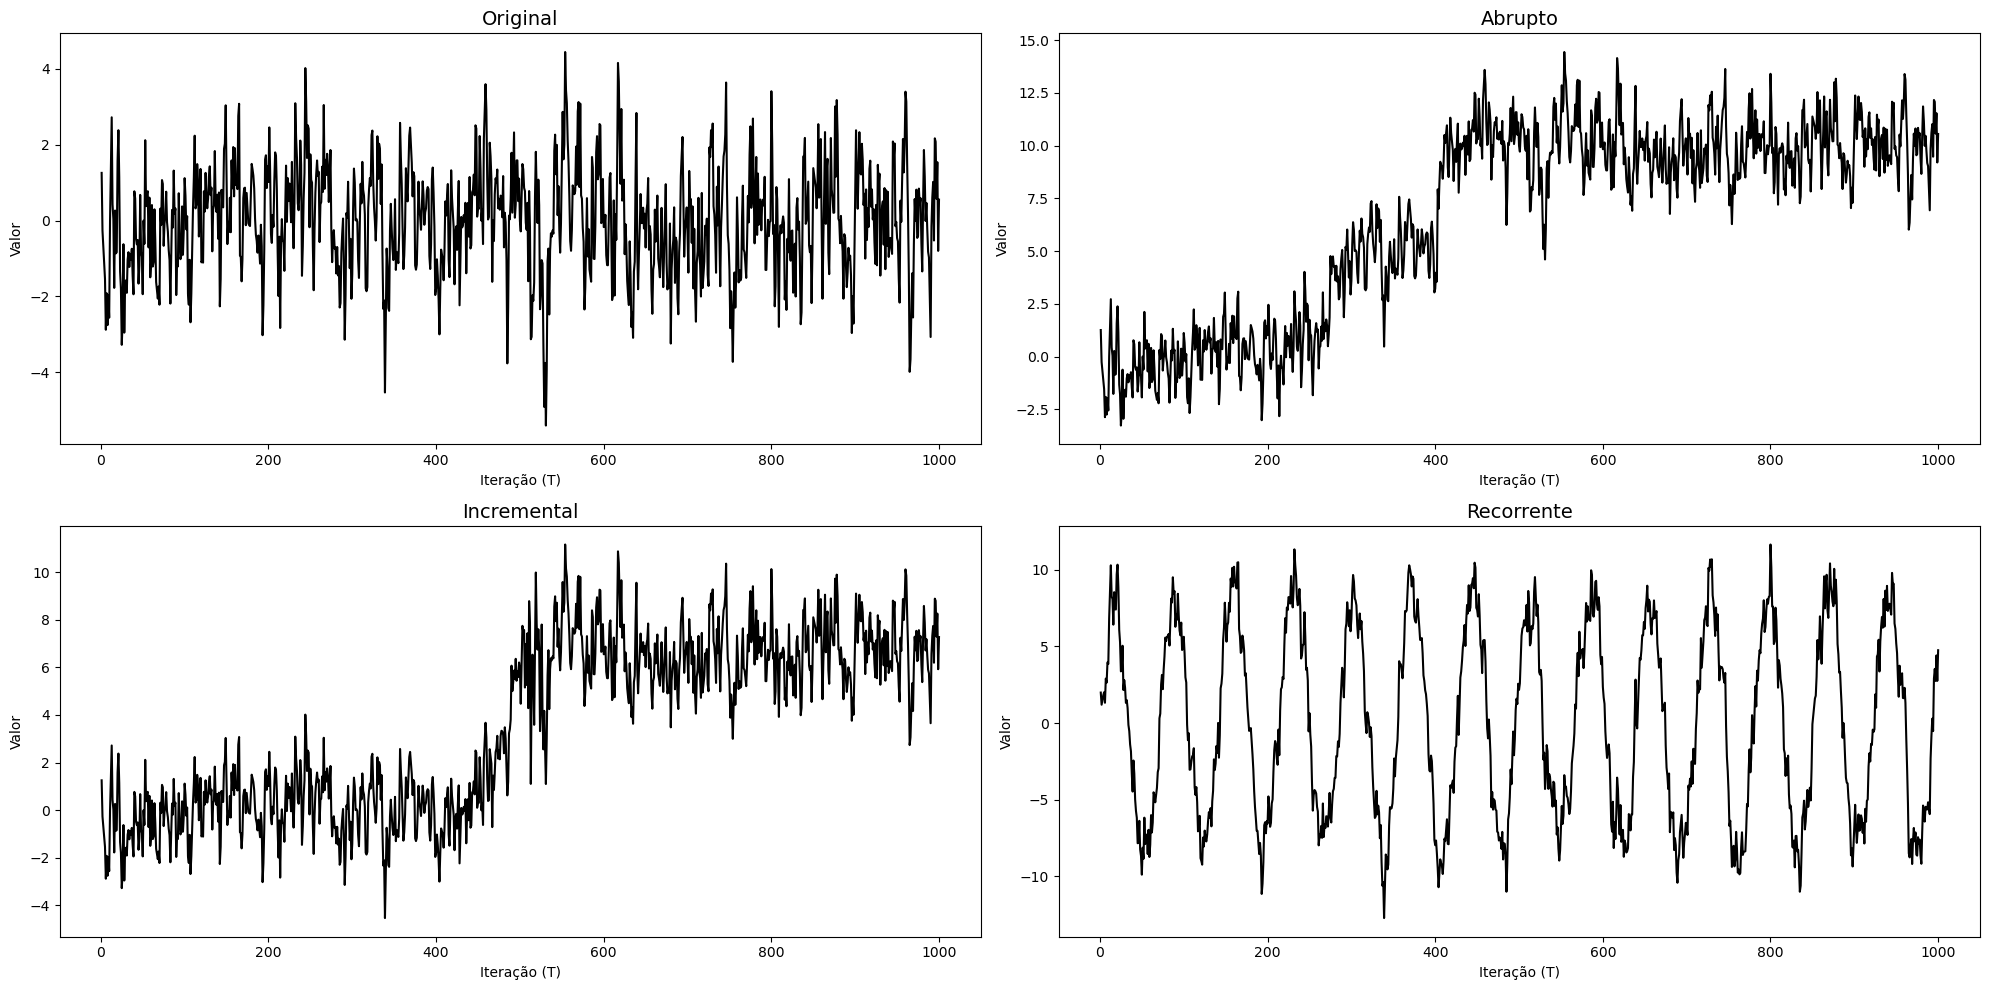

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Cria uma grade de subplots 2x2

# Configurações dos títulos dos subplots
titles = ['Original', 'Abrupto', 'Incremental', 'Recorrente']

# Plotagem do primeiro gráfico
axs[0, 0].plot(df.t, df.V1, color='black')
axs[0, 0].set_title('Original',fontsize=14)
axs[0, 0].set_xlabel('Iteração (T)')
axs[0, 0].set_ylabel('Valor')

# Plotagem do segundo gráfico
axs[0, 1].plot(df_abrupto.t, df_abrupto.V1, color='black')
axs[0, 1].set_title('Abrupto',fontsize=14)
axs[0, 1].set_xlabel('Iteração (T)')
axs[0, 1].set_ylabel('Valor')

# Plotagem do terceiro gráfico
axs[1, 0].plot(df_incremental.t, df_incremental.V1, color='black')
axs[1, 0].set_title('Incremental',fontsize=14)
axs[1, 0].set_xlabel('Iteração (T)')
axs[1, 0].set_ylabel('Valor')

# Plotagem do quarto gráfico
axs[1, 1].plot(df_recorrente.t, df_recorrente.V1, color='black')
axs[1, 1].set_title('Recorrente',fontsize=14)
axs[1, 1].set_xlabel('Iteração (T)')
axs[1, 1].set_ylabel('Valor')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Salvar a figura
plt.savefig('../imagens/series_simuladas.png')

plt.show()